In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns 

from collections import Counter
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import train_test_split
%matplotlib inline

/Users/Vera/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Load data
schars = pd.read_csv('simpsons_characters.csv')
sepisodes = pd.read_csv('simpsons_episodes.csv')
slines = pd.read_csv('simpsons_script_lines.csv', error_bad_lines=False, warn_bad_lines=False, low_memory=False)
locations = pd.read_csv('simpsons_locations.csv', error_bad_lines=False, warn_bad_lines=False, low_memory=False)

In [3]:
sepisodes

,id,title,original_air_date,production_code,season,number_in_season,number_in_series,us_viewers_in_millions,views,imdb_rating,imdb_votes,image_url,video_url
0,10,Homer's Night Out,1990-03-25,7G10,1,10,10,30.30,50816.0,7.4,1511.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/275197507879
1,12,Krusty Gets Busted,1990-04-29,7G12,1,12,12,30.40,62561.0,8.3,1716.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/288019523914
2,14,"Bart Gets an ""F""",1990-10-11,7F03,2,1,14,33.60,59575.0,8.2,1638.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/260539459671
3,17,Two Cars in Every Garage and Three Eyes on Eve...,1990-11-01,7F01,2,4,17,26.10,64959.0,8.1,1457.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/260537411822
4,19,Dead Putting Society,1990-11-15,7F08,2,6,19,25.40,50691.0,8.0,1366.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/260539459670
5,21,Bart the Daredevil,1990-12-06,7F06,2,8,21,26.20,57605.0,8.4,1522.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/260539459702
6,23,Bart Gets Hit by a Car,1991-01-10,7F10,2,10,23,24.80,56486.0,7.8,1340.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/260550723760
7,26,Homer vs. Lisa and the 8th Commandment,1991-02-07,7F13,2,13,26,26.20,58277.0,8.0,1329.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/260820547692
8,28,"Oh Brother, Where Art Thou?",1991-02-21,7F16,2,15,28,26.80,47426.0,8.2,1413.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/272046659561
9,30,Old Money,1991-03-28,7F17,2,17,30,21.20,44331.0,7.6,1243.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/263504963955


## Підготуємо та дослідимо дані

### Додамо дані про кількість персонажів у епізоді, кількість локацій та кількість слів

In [10]:
sepisodes['num_characters'] = 0
sepisodes['words_count'] = 0
sepisodes['num_locations'] = 0

for id in sepisodes['id']:
    num_characters = len(slines[slines['episode_id'] == id].dropna().character_id.drop_duplicates())
    words_count = slines[slines['episode_id'] == id].dropna().word_count.sum()
    num_locations = len(slines[slines['episode_id'] == id].dropna().location_id.drop_duplicates())
    sepisodes.set_value(sepisodes['id'] == id, 'num_characters', num_characters)
    sepisodes.set_value(sepisodes['id'] == id, 'words_count', words_count)
    sepisodes.set_value(sepisodes['id'] == id, 'num_locations', num_locations)
    
sepisodes[['id', 'num_characters', 'words_count', 'num_locations']].head(5)

,id,num_characters,words_count,num_locations
0,10,40,2521.0,28
1,12,33,2788.0,15
2,14,27,2646.0,18
3,17,28,2764.0,14
4,19,14,2688.0,13


In [5]:
row = slines[slines['episode_id'] == 10]
#row2 = row.dropna().groupby('character_id')['word_count'].sum()

## Average IMDB Rating of Seasons

In [6]:
# remove 27 season
episodes = sepisodes[sepisodes.season != 28]

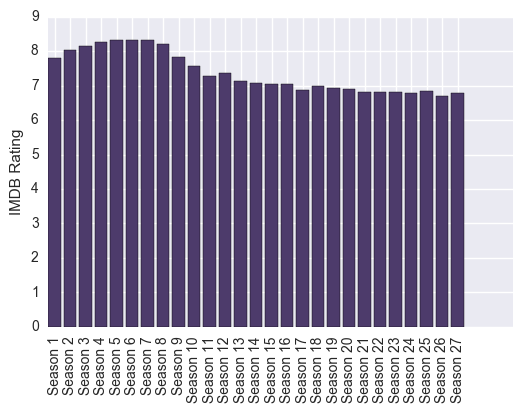

In [7]:
mean_episode_ratings = episodes.groupby('season')['imdb_rating'].mean()
ind = np.arange(len(mean_episode_ratings))
labels = ["Season {season}".format(season = season) for season in mean_episode_ratings.index]
plt.bar(ind, mean_episode_ratings, color=(.3,.23,.42))
plt.gca().set_xticks(ind + .4)
plt.gca().set_xticklabels(labels)
plt.ylabel("IMDB Rating")
plt.xticks(rotation=90)
plt.show()

## Average Viewers of Seasons

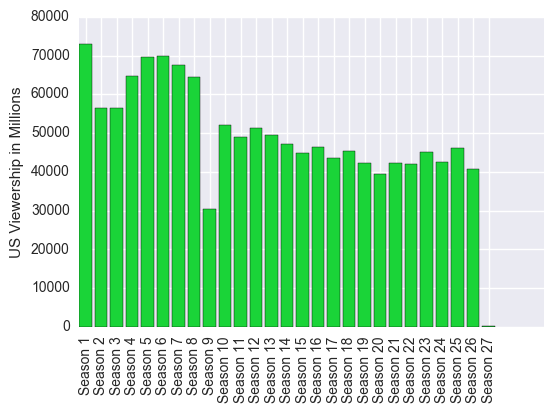

In [8]:
mean_episode_views = episodes.groupby('season')['views'].mean()
ind = np.arange(len(mean_episode_views))
labels = ["Season {season}".format(season = season) for season in mean_episode_views.index]
plt.bar(ind, mean_episode_views, color=(.1,.83,.22))
plt.gca().set_xticks(ind + .4)
plt.gca().set_xticklabels(labels)
plt.ylabel("US Viewership in Millions")
plt.xticks(rotation=90)
plt.show()

## кореляція мож кількостю переглядів (діалогів, кількості серії і тд) від рейтингу сезону

/Users/Vera/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


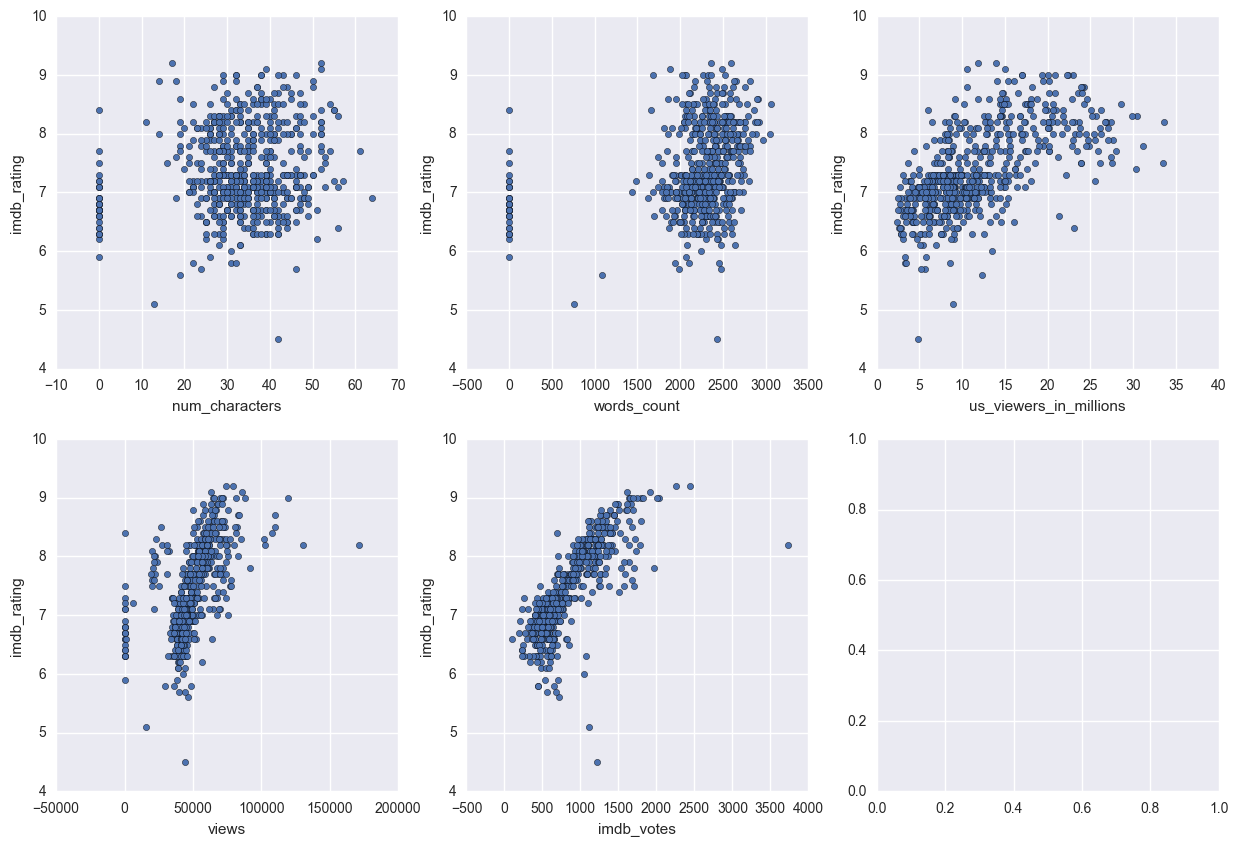

In [9]:
episodes_data = sepisodes[['num_characters', 'words_count', '' 'us_viewers_in_millions','views','imdb_votes','imdb_rating']]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for idx, feature in enumerate(episodes_data.columns[:-1]):
    episodes_data.plot(feature, "imdb_rating", subplots=True, kind="scatter", ax=axes[idx / 3, idx % 3])

признаки
1. преобладающий пол -
2. us_viewers_in_millions +
3. views +
4. imbd_votes + 
5. кол-во персонажей + 
6. кол-во локаций +
7. кол-во слова +
8. кто болше всех говорит -
9. основная локация -


Графики:
1. locations / words count https://www.kaggle.com/qazcat/d/wcukierski/the-simpsons-by-the-data/characters-by-location
2. м/ж https://www.kaggle.com/danielcmessias/d/wcukierski/the-simpsons-by-the-data/notebook8e6308cb7e
3. кол-во слов каждого персонажа https://www.kaggle.com/danielcmessias/d/wcukierski/the-simpsons-by-the-data/notebook8e6308cb7e
4. Conversations intensity graph https://www.kaggle.com/david101/d/wcukierski/the-simpsons-by-the-data/conversations-intensity-graph
5. words cloud - https://www.kaggle.com/rivanor/d/wcukierski/the-simpsons-by-the-data/wordclouds-from-springfield-people

обучение 

1. нормировать данные?

сделать за выходные
1. графики
2. признаки
3. линейная регрессия